# Setup

In [1]:
import pandas as pd
import seaborn as sns
import os
import linecache

from src.profiling import load_pkl
from src.viz import plot_grouped_barchart, convert_shortened_bytes_to_int, bytes_to_readable_fmt
import tracemalloc
import warnings
import yappi
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# Analyze Overall Results

In [117]:
# files_to_load = ['profiling_4', 'profiling_5', 'profiling_6']

files_to_load = ['profiling_10_workers']

results = []
for file in files_to_load:
    results += load_pkl(f"{os.getcwd()}/profiles/{file}.pkl")


df = pd.DataFrame.from_records(results)

for col in ['total_runtime_seconds', 'setup_runtime_seconds', 'evaluation_runtime_seconds']:
    df[col.replace('_seconds', '_minutes')] = df[col] / 60

# parse docker output into bytes
for col in ['postgis/postgis_disk_space', 'redis_disk_space']:
    split_df = df.loc[:, col].str.split('(', expand=True)
    split_df[1] = split_df[1].replace(to_replace='\)', value="", regex=True).replace(to_replace='virtual ', value="", regex=True)
    split_df = split_df.applymap(convert_shortened_bytes_to_int)
    split_df.columns = [f'{col}_used', f'{col}_virtual']
    split_df[f'{col}_total'] = split_df.sum(axis=1)
    df = pd.concat([df, split_df], axis=1)

for col in ['postgis/postgis_cpu_util', 'redis_cpu_util', 'postgis/postgis_mem_util', 'redis_mem_util']:
    df[col] = df[col].str.rstrip('%').astype('float') / 100.0


# combine tracemalloc columns
df['client_tracemalloc_top10'] = df[[i for i in range(10)]].apply(dict, axis=1)
df.drop([i for i in range(10)], axis=1, inplace=True)
df

,client,dataset_name,model_name,n_images,n_predictions,n_annotations,n_labels,start,total_runtime_seconds,setup_runtime_seconds,...,total_runtime_minutes,setup_runtime_minutes,evaluation_runtime_minutes,postgis/postgis_disk_space_used,postgis/postgis_disk_space_virtual,postgis/postgis_disk_space_total,redis_disk_space_used,redis_disk_space_virtual,redis_disk_space_total,client_tracemalloc_top10
0,<velour.client.Client object at 0x14f955b50>,profiling_10_workers,profiling_10_workers_model,10,2,2,2,89078.299769,10.67,4.14,...,0.177833,0.069000,0.108000,63,621805568,621805631,0,191889408,191889408,{0: {'filename': '/Users/nthorlind/git/sw/velo...
1,<velour.client.Client object at 0x14f955b50>,profiling_10_workers,profiling_10_workers_model,100,2,2,2,89091.734262,50.11,19.37,...,0.835167,0.322833,0.510500,63,621805568,621805631,0,191889408,191889408,{0: {'filename': '/Users/nthorlind/git/sw/velo...
2,<velour.client.Client object at 0x14f955b50>,profiling_10_workers,profiling_10_workers_model,1000,2,2,2,89144.594743,484.36,186.65,...,8.072667,3.110833,4.959667,63,621805568,621805631,0,191889408,191889408,{0: {'filename': '/Users/nthorlind/git/sw/velo...
3,<velour.client.Client object at 0x14f955b50>,profiling_10_workers,profiling_10_workers_model,10000,2,2,2,89631.715514,5529.65,2257.44,...,92.160833,37.624000,54.534667,63,621805568,621805631,0,191889408,191889408,{0: {'filename': '/Users/nthorlind/git/sw/velo...


In [118]:
df.columns

Index(['client', 'dataset_name', 'model_name', 'n_images', 'n_predictions',
       'n_annotations', 'n_labels', 'start', 'total_runtime_seconds',
       'setup_runtime_seconds', 'evaluation_runtime_seconds', 'exception',
       'redis_disk_space', 'redis_cpu_util', 'redis_mem_util',
       'postgis/postgis_disk_space', 'postgis/postgis_cpu_util',
       'postgis/postgis_mem_util', 'total_runtime_minutes',
       'setup_runtime_minutes', 'evaluation_runtime_minutes',
       'postgis/postgis_disk_space_used', 'postgis/postgis_disk_space_virtual',
       'postgis/postgis_disk_space_total', 'redis_disk_space_used',
       'redis_disk_space_virtual', 'redis_disk_space_total',
       'client_tracemalloc_top10'],
      dtype='object')

## Total Runtime

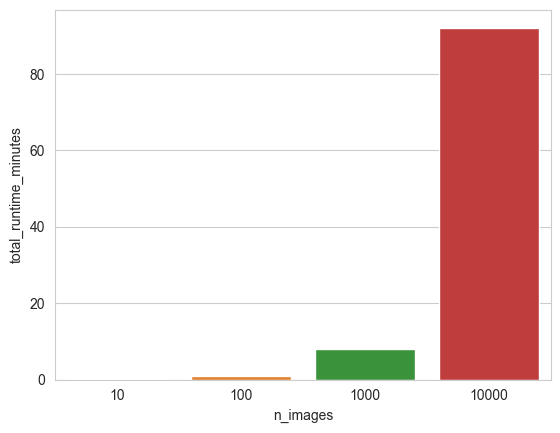

In [119]:
plot_grouped_barchart(df=df, x="n_images", y="total_runtime_minutes", hue=None)


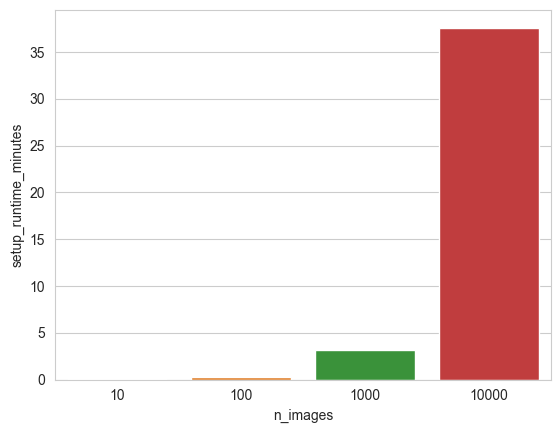

In [120]:
plot_grouped_barchart(df=df, x="n_images", y="setup_runtime_minutes", hue=None)


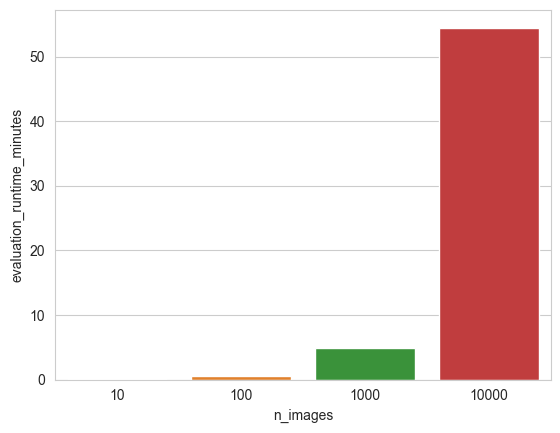

In [121]:
plot_grouped_barchart(df=df, x="n_images", y="evaluation_runtime_minutes", hue=None)


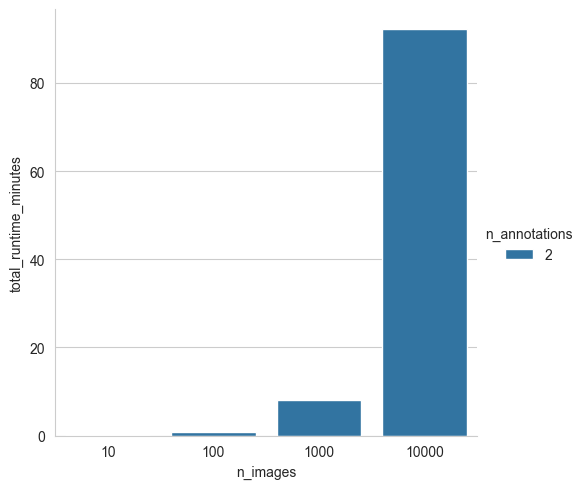

In [122]:
plot_grouped_barchart(df=df, x="n_images", y="total_runtime_minutes", hue='n_annotations')


## Docker Stats

### postgis

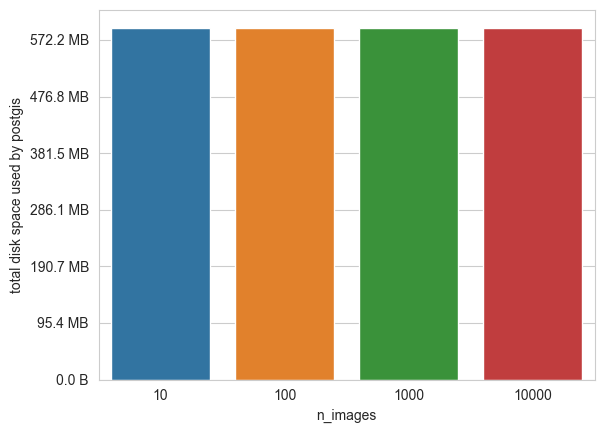

In [123]:
plot_grouped_barchart(df=df, x="n_images", y="postgis/postgis_disk_space_total", hue=None, y_axis_label='total disk space used by postgis', convert_bytes=True)


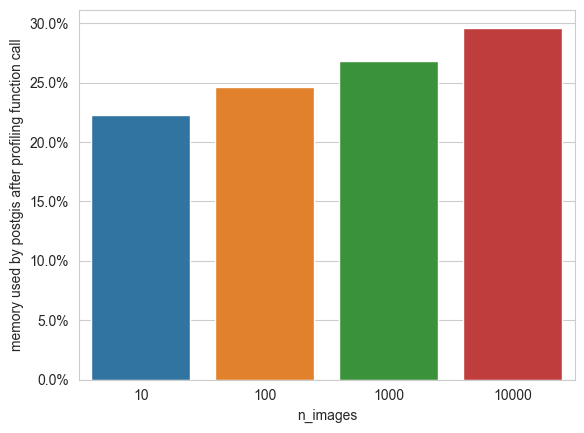

In [124]:
# NOTE: mem_util is the memory usage at the time the snapshot was taken, not the overall peak memory usage
plot_grouped_barchart(df=df, x="n_images", y="postgis/postgis_mem_util", hue=None, y_axis_label='memory used by postgis after profiling function call', convert_perc=True)

### redis

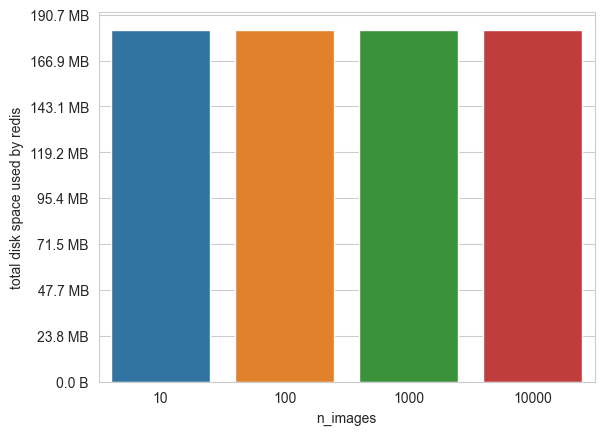

In [125]:
plot_grouped_barchart(df=df, x="n_images", y="redis_disk_space_total", hue=None, y_axis_label='total disk space used by redis', convert_bytes=True)


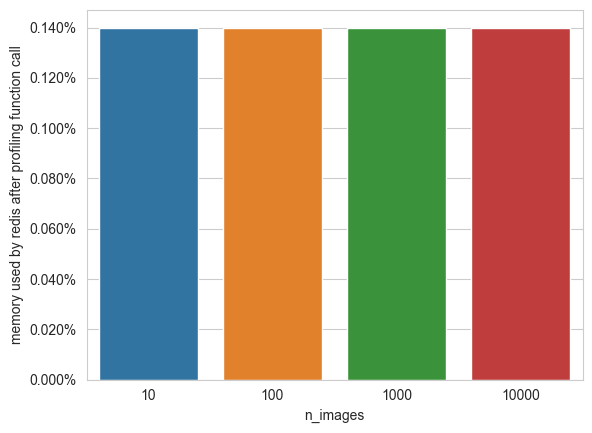

In [126]:
# NOTE: mem_util is the memory usage at the time the snapshot was taken, not the overall peak memory usage
plot_grouped_barchart(df=df, x="n_images", y="redis_mem_util", hue=None, y_axis_label='memory used by redis after profiling function call', convert_perc=True)

# Analyze Backend Profiles

## cprofile

Use this command to analyze CProfile reports in snakeviz:

```
snakeviz utils/profiles/create_groundtruths.cprofile
snakeviz utils/profiles/create_predictions.cprofile
snakeviz utils/profiles/create_ap_metrics.cprofile

```

## tracemalloc

### create_groundtruth

In [127]:
function_to_analyze = 'create_groundtruths'

def _print_tracemalloc_peaks(dct:dict):
    size_pct = (dct["second_size"]-dct["first_size"])/dct["first_size"]
    print(f'Original size: {bytes_to_readable_fmt(dct["first_size"], 0)}')
    print(f'Final size: {bytes_to_readable_fmt(dct["second_size"], 0)}')
    print(f'Percent Change: {size_pct:2%}')
    print('')

tracemalloc_path = f'profiles/{function_to_analyze}.tracemalloc'
snapshot = tracemalloc.Snapshot.load(tracemalloc_path)
tracemalloc_dct = load_pkl(tracemalloc_path + '.pkl')


_print_tracemalloc_peaks(tracemalloc_dct)

Original size: 8.7 MB
Final size: 8.8 MB
Percent Change: 1.756496%



In [128]:

def _display_top_tracemalloc(snapshot:tracemalloc.Snapshot, key_type:str='lineno', limit:int=10):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
        tracemalloc.Filter(True, '*/velour/*')
    ))
    top_stats = snapshot.statistics(key_type)

    print("Top %s lines" % limit)
    for index, stat in enumerate(top_stats[:limit], 1):
        frame = stat.traceback[0]
        print("#%s: %s:%s: %.1f KiB"
              % (index, frame.filename, frame.lineno, stat.size / 1024))
        line = linecache.getline(frame.filename, frame.lineno).strip()
        if line:
            print('    loc: %s:%s' % (frame.filename, frame.lineno))
            print('    func: %s' % line)

    other = top_stats[limit:]
    if other:
        size = sum(stat.size for stat in other)
        print("%s other: %.1f KiB" % (len(other), size / 1024))
    total = sum(stat.size for stat in top_stats)
    print("Total allocated size: %.1f KiB" % (total / 1024))

_display_top_tracemalloc(snapshot=snapshot)

Top 10 lines
#1: /Users/nthorlind/git/sw/velour/utils/src/profiling.py:68: 3.3 KiB
    loc: /Users/nthorlind/git/sw/velour/utils/src/profiling.py:68
    func: with open(
#2: /Users/nthorlind/git/sw/velour/utils/src/profiling.py:193: 1.6 KiB
    loc: /Users/nthorlind/git/sw/velour/utils/src/profiling.py:193
    func: profiler.disable()
#3: /Users/nthorlind/git/sw/velour/utils/src/profiling.py:55: 1.3 KiB
    loc: /Users/nthorlind/git/sw/velour/utils/src/profiling.py:55
    func: first_size, first_peak = tracemalloc.get_traced_memory()
#4: /Users/nthorlind/git/sw/velour/api/velour_api/backend/core/annotation.py:294: 1.1 KiB
    loc: /Users/nthorlind/git/sw/velour/api/velour_api/backend/core/annotation.py:294
    func: def get_annotation_type(
#5: /Users/nthorlind/git/sw/velour/api/velour_api/backend/query/label.py:46: 1.1 KiB
    loc: /Users/nthorlind/git/sw/velour/api/velour_api/backend/query/label.py:46
    func: def _get_model_labels(
#6: /Users/nthorlind/git/sw/velour/api/velour_api/

### create_predictions

In [129]:
function_to_analyze = 'create_predictions'

tracemalloc_path = f'profiles/{function_to_analyze}.tracemalloc'
snapshot = tracemalloc.Snapshot.load(tracemalloc_path)
tracemalloc_dct = load_pkl(tracemalloc_path + '.pkl')


_print_tracemalloc_peaks(tracemalloc_dct)

Original size: 4.6 MB
Final size: 4.8 MB
Percent Change: 2.968546%



In [130]:
_display_top_tracemalloc(snapshot=snapshot)

Top 10 lines
#1: /Users/nthorlind/git/sw/velour/utils/src/profiling.py:68: 2.3 KiB
    loc: /Users/nthorlind/git/sw/velour/utils/src/profiling.py:68
    func: with open(
#2: /Users/nthorlind/git/sw/velour/api/velour_api/backend/jobs.py:66: 1.2 KiB
    loc: /Users/nthorlind/git/sw/velour/api/velour_api/backend/jobs.py:66
    func: return Stateflow(**info)
#3: /Users/nthorlind/git/sw/velour/api/velour_api/backend/core/annotation.py:25: 0.9 KiB
    loc: /Users/nthorlind/git/sw/velour/api/velour_api/backend/core/annotation.py:25
    func: def create_annotation(
#4: /Users/nthorlind/git/sw/velour/utils/src/profiling.py:55: 0.9 KiB
    loc: /Users/nthorlind/git/sw/velour/utils/src/profiling.py:55
    func: first_size, first_peak = tracemalloc.get_traced_memory()
#5: /Users/nthorlind/git/sw/velour/api/velour_api/backend/stateflow.py:97: 0.9 KiB
    loc: /Users/nthorlind/git/sw/velour/api/velour_api/backend/stateflow.py:97
    func: def wrapper(*args, **kwargs):
#6: /Users/nthorlind/git/sw/vel

### create_ap_metrics

In [131]:
function_to_analyze = 'create_ap_metrics'

tracemalloc_path = f'profiles/{function_to_analyze}.tracemalloc'
snapshot = tracemalloc.Snapshot.load(tracemalloc_path)
tracemalloc_dct = load_pkl(tracemalloc_path + '.pkl')


_print_tracemalloc_peaks(tracemalloc_dct)

Original size: 12.0 MB
Final size: 12.2 MB
Percent Change: 1.786899%



In [132]:
_display_top_tracemalloc(snapshot=snapshot)

Top 10 lines
#1: /Users/nthorlind/git/sw/velour/utils/src/profiling.py:68: 3.1 KiB
    loc: /Users/nthorlind/git/sw/velour/utils/src/profiling.py:68
    func: with open(
#2: /Users/nthorlind/git/sw/velour/api/velour_api/backend/core/annotation.py:294: 1.3 KiB
    loc: /Users/nthorlind/git/sw/velour/api/velour_api/backend/core/annotation.py:294
    func: def get_annotation_type(
#3: /Users/nthorlind/git/sw/velour/api/velour_api/backend/query/label.py:46: 1.2 KiB
    loc: /Users/nthorlind/git/sw/velour/api/velour_api/backend/query/label.py:46
    func: def _get_model_labels(
#4: /Users/nthorlind/git/sw/velour/utils/src/profiling.py:55: 1.2 KiB
    loc: /Users/nthorlind/git/sw/velour/utils/src/profiling.py:55
    func: first_size, first_peak = tracemalloc.get_traced_memory()
#5: /Users/nthorlind/git/sw/velour/api/velour_api/backend/core/label.py:105: 1.0 KiB
    loc: /Users/nthorlind/git/sw/velour/api/velour_api/backend/core/label.py:105
    func: def get_dataset_labels_query(
#6: /Users/

## yappi

NOTE: This profiler is difficult to visualize without kCacheGrind. Prefer cprofile for now.

In [133]:
stats = yappi.get_func_stats()
stats.add("profiles/create_groundtruths.yappi")

stats.sort("tsub", "desc").print_all()


Clock type: WALL
Ordered by: tsub, desc

name                                  ncall  tsub      ttot      tavg      
..hon3.11/asyncio/tasks.py:627 sleep  9107   129481.6  129481.8  14.21784
..y:311 _set_result_unless_cancelled  9107   0.078827  0.199299  0.000022
..ils/src/profiling.py:184 wrap_func  681..  0.066243  2808.989  0.412117
..icorn/server.py:235 Server.on_tick  9107   0.046949  0.113229  0.000012
...py:117 _format_timetuple_and_zone  923    0.015076  0.015076  0.000016
..3.11/email/utils.py:126 formatdate  923    0.010571  0.059457  0.000064
..email/utils.py:155 format_datetime  923    0.007159  0.036102  0.000039
..orn/server.py:226 Server.main_loop  1      0.000000  0.000000  0.000000
../uvicorn/server.py:63 Server.serve  1      0.000000  0.000000  0.000000


In [134]:
stats = yappi.get_func_stats()
stats.add("profiles/create_predictions.yappi")

stats.sort("tsub", "desc").print_all()


Clock type: WALL
Ordered by: tsub, desc

name                                  ncall  tsub      ttot      tavg      
..hon3.11/asyncio/tasks.py:627 sleep  3614   280946.1  280946.3  77.73832
..ils/src/profiling.py:184 wrap_func  351..  0.032389  6034.516  1.719235
..y:311 _set_result_unless_cancelled  3614   0.032153  0.075868  0.000021
..icorn/server.py:235 Server.on_tick  3614   0.018563  0.044174  0.000012
...py:117 _format_timetuple_and_zone  350    0.005731  0.005731  0.000016
..3.11/email/utils.py:126 formatdate  350    0.003741  0.023110  0.000066
..email/utils.py:155 format_datetime  350    0.002752  0.014919  0.000043
..b/python3.11/weakref.py:369 remove  208    0.000468  0.000468  0.000002
../uvicorn/server.py:63 Server.serve  1      0.000000  0.000000  0.000000
..orn/server.py:226 Server.main_loop  1      0.000000  0.000000  0.000000


In [135]:
stats = yappi.get_func_stats()
stats.add("profiles/create_ap_metrics.yappi")

stats.sort("tsub", "desc").print_all()


Clock type: WALL
Ordered by: tsub, desc

name                                  ncall  tsub      ttot      tavg      
..hon3.11/asyncio/tasks.py:627 sleep  14885  250577.5  250578.0  16.83426
..y:311 _set_result_unless_cancelled  14885  0.127071  0.322413  0.000022
..ils/src/profiling.py:184 wrap_func  115..  0.110281  6037.402  0.522900
..icorn/server.py:235 Server.on_tick  14885  0.075394  0.182332  0.000012
...py:117 _format_timetuple_and_zone  1491   0.023948  0.023948  0.000016
..3.11/email/utils.py:126 formatdate  1491   0.016809  0.096183  0.000065
..email/utils.py:155 format_datetime  1491   0.011179  0.058625  0.000039
..b/python3.11/weakref.py:369 remove  364    0.000778  0.000778  0.000002
..orn/server.py:226 Server.main_loop  1      0.000000  0.000000  0.000000
../uvicorn/server.py:63 Server.serve  1      0.000000  0.000000  0.000000
